# Example

In [1]:
import banditpylib
import numpy as np
import json
import pprint
from matplotlib.pyplot import figure
from tabulate import tabulate

## Use policies in library

In [2]:
config_file = 'config.json'
# load config file
with open(config_file, 'r') as json_file:
    config = json.load(json_file)

In [3]:
pprint.pprint(config)

{'environment': {'bandit': 'OrdinaryBandit',
                 'params': {'arm': 'BernoulliArm', 'means': [0.3, 0.5, 0.7]}},
 'learners': {'goal': 'regretmin',
              'policies': [{'params': {'name': 'Uniform Sampling',
                                       'type': 'ordinarylearner'},
                            'policy': 'Uniform'},
                           {'params': {'name': 'UCB1',
                                       'type': 'ordinarylearner'},
                            'policy': 'UCB'},
                           {'params': {'horizon': 2000,
                                       'type': 'ordinarylearner'},
                            'policy': 'MOSS'},
                           {'params': {'name': 'Thompson Sampling',
                                       'type': 'ordinarylearner'},
                            'policy': 'TS'}]},
 'running': {'freq': 20, 'horizon': 2000, 'processors': -1, 'trials': 200}}


In [4]:
# add `debug=True` in the arguments if you want more detailed runtime info or try to debug
data = banditpylib.run(config)

I0307 12:03:55.043314 4786146752 __init__.py:223] run with goal Regret Minimization
I0307 12:03:55.045204 4786146752 utils.py:111] run Uniform Sampling with protocol SinglePlayerRegretMinProtocol
I0307 12:03:56.718616 4786146752 utils.py:119] 1.67 seconds elapsed
I0307 12:03:56.722079 4786146752 utils.py:111] run UCB1 with protocol SinglePlayerRegretMinProtocol
I0307 12:04:01.274883 4786146752 utils.py:119] 4.55 seconds elapsed
I0307 12:04:01.277658 4786146752 utils.py:111] run MOSS with protocol SinglePlayerRegretMinProtocol
I0307 12:04:05.931133 4786146752 utils.py:119] 4.65 seconds elapsed
I0307 12:04:05.933440 4786146752 utils.py:111] run Thompson Sampling with protocol SinglePlayerRegretMinProtocol
I0307 12:04:09.651701 4786146752 utils.py:119] 3.72 seconds elapsed


I0307 12:04:09.904860 4786146752 utils.py:141] NumExpr defaulting to 8 threads.


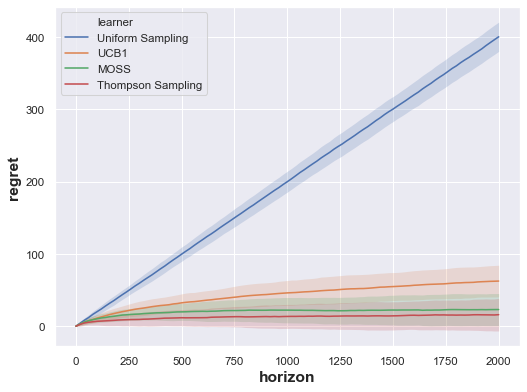

In [5]:
figure(figsize=(8, 6), dpi=75)
# add `save_fig=FILEPATH` in the arguments if you want to save the figure
df = banditpylib.plot(data)

In [6]:
print(tabulate(df.head(), headers=["policy", "regret"]))

policy          regret
------------  --------
('MOSS', 0)      0
('MOSS', 20)     3.325
('MOSS', 40)     5.64
('MOSS', 60)     7.535
('MOSS', 80)     8.945


## Add a new policy

In [7]:
from banditpylib.learners.regretmin import ordinarylearner

In [8]:
# time starts from 1
# arm index starts from 0
# self._t and self._em_arms are inherited from parent class
class ExploreThenCommit(ordinarylearner.OrdinaryLearner):
  def __init__(self, T_zero):
    self._name = 'Explore-Then-Commit'
    self.__T_zero = T_zero

  def _learner_init(self):
    # called before the start of each trial
    self.__commit = None
    pass

  def learner_choice(self, context):
    # during each time step, this method will be called by automatically by the protocol
    # context is useless
    del context
    if self._t <= self.__T_zero:
        # pull each arm in a round-robin way
        return (self._t-1) % self._arm_num
    if not self.__commit:
        self.__commit = np.argmax([em_arm.em_mean for em_arm in self._em_arms])
    return self.__commit

  def _learner_update(self, context, action, feedback):
    # called after each time step reward is revealed
    pass

In [9]:
policies = [ExploreThenCommit(100)]

In [10]:
data = banditpylib.run(config, new_policies=policies)

I0307 12:04:10.458157 4786146752 __init__.py:223] run with goal Regret Minimization
I0307 12:04:10.459293 4786146752 utils.py:111] run Uniform Sampling with protocol SinglePlayerRegretMinProtocol
I0307 12:04:12.235732 4786146752 utils.py:119] 1.78 seconds elapsed
I0307 12:04:12.238586 4786146752 utils.py:111] run UCB1 with protocol SinglePlayerRegretMinProtocol
I0307 12:04:17.201454 4786146752 utils.py:119] 4.96 seconds elapsed
I0307 12:04:17.204198 4786146752 utils.py:111] run MOSS with protocol SinglePlayerRegretMinProtocol
I0307 12:04:22.271816 4786146752 utils.py:119] 5.07 seconds elapsed
I0307 12:04:22.274253 4786146752 utils.py:111] run Thompson Sampling with protocol SinglePlayerRegretMinProtocol
I0307 12:04:26.408319 4786146752 utils.py:119] 4.13 seconds elapsed
I0307 12:04:26.411238 4786146752 utils.py:111] run Explore-Then-Commit with protocol SinglePlayerRegretMinProtocol
I0307 12:04:28.468829 4786146752 utils.py:119] 2.06 seconds elapsed


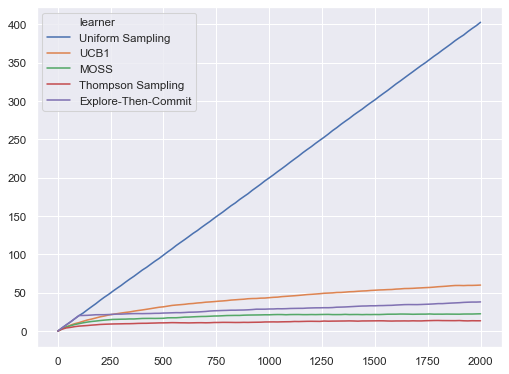

In [11]:
figure(figsize=(8, 6), dpi=75)
df = banditpylib.plot(data, novar=True)